In [1]:
import collections
import os
import os.path
import random
import re
import glob
import pandas as pd
import requests
import json
import math
import nltk
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
import seaborn
import scipy as sp

# cluster detection
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition

# topic modelling
import gensim
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger

# DTM
import pyLDAvis

# NLP
import stanza
stanza.download('ru')

2020-06-20 17:44:06 INFO: Downloading default packages for language: ru (Russian)...
2020-06-20 17:44:08 INFO: File exists: /Users/Leha/stanza_resources/ru/default.zip.
2020-06-20 17:44:16 INFO: Finished downloading models and saved to /Users/Leha/stanza_resources.


The first step is gathering my data. Here, all of my texts are already downloaded to my hard drive, and grouped according to year. The following cell calls the directory in which my texts are located, and reads all of the .txt files there. All of the text from each .txt file is then appended to a list. The file name of each .txt file is the appended to a seperate list, alongside the spedified year. This process is repeated for every year, changing only the target directory and year.

In [ ]:
# creating dataframes from text


targetDir = '/Users/Leha/Desktop/Izvestia/Abby_Fine_Reader_Extracted_Text/1997_txt'
izvestiiaText = []
izvestiiaFileName = []
IzvestiiaYear = []
year = "1997"


for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path, encoding="utf-8") as f:
        izvestiiaText.append(f.read())
    izvestiiaFileName.append(file.name)
    IzvestiiaYear.append(year)
    Izvestiiatype.append(t)

The lists from the previous cell are then converted into a Pandas DataFrame (essentailly an excel spreadsheet), where each list from above gets its own column. Text goes into the "text" column, filename into the "filename" column. Since the code above adds items to each list sequentially, each text is properly matched to its filename and year. This process is also repeated for every year.

In [ ]:
izvestiia_df1997 = pandas.DataFrame({'text' : izvestiiaText, 'year':IzvestiiaYear, 'filename':izvestiiaFileName})

Finally all of the resultant dataframes are combined into one large dataframe.

In [ ]:
# creating dataframe from all texts
df = pd.concat([izvestiia_df1984, izvestiia_df1985, izvestiia_df1986, ..., izvestiia_df1996, izvestiia_df1997])

In [9]:
# Final product:
df = pd.read_json("izvestiia_text.json")
df

,text,year,filename
0,ПРАВОВОЕ ВОСПИТАНИЕ МОЛОДЕЖИ\n\nЛЛДИН мз «Днем...,1984,1984 Issue 082 Page 1.txt
1,"ЗЕМЛЯ, ПЛАН И ЛЮДИ\n\nМЫ ЛЮБИМ говорить: земля...",1984,1984 Issue 082 Page 2.txt
2,В Президиумах Доеных Советов союзных республик...,1984,1984 Issue 082 Page 3.txt
3,по странам и континентам\n\nновости\n\n\t\t\t\...,1984,1984 Issue 082 Page 4.txt
4,Фотоатлас «Известий»\n\nВьетнам\n\nИзо дня в д...,1984,1984 Issue 082 Page 5.txt
...,...,...,...
1299,﻿№ 94 •\nИЗВЕСТИЯ\n22 мая 1997 года • 4^\nИрин...,1997,1997 Issue 94 May 22 Page 5.txt
1300,﻿№ 94 •\nИЗВЕСТИЯ\nБОЛЬШИЕ\nОЗМОЖНОСТИ\nРОСТА\...,1997,1997 Issue 94 May 22 Page 6.txt
1301,﻿БРОКЕРСКАЯ КОМПАНИЯ\nФЫОЧ1РСЫ и ОПЦИОНЫ на АК...,1997,1997 Issue 94 May 22 Page 7.txt
1302,"﻿II • 22 мая 1997 г., четверг\nБИЗНЕС И ЭКОНОМ...",1997,1997 Issue 94 May 22 Page 8.txt


Before text procesing can begin, the texts need to be proprocessed and cleaned. The following function removes all characters from the text that are not present within the brackets. In other words, all non-Cyryllic and all punctuation except for ".,?!"

In [13]:
def text_cleaner(text):
    return re.sub('[^а-яА-Я\s.,?!]', '', text)

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
<ipython-input-13-3bc1d9c5b071>:2: DeprecationWarning: invalid escape sequence \s
  return re.sub('[^а-яА-Я\s.,?!]', '', text)


Create a new column in the dataframe for the cleaned text.

In [14]:
df['clean_text'] = df['text'].apply(lambda x: text_cleaner(x))

In order to preserve the formating of the text, Python represented certain formatting using escape sequences. \n represents a newline and \t represents a tab. We are not interested in preserving this formatting, and the presence of escape sequences can mess up text processing, so the following function removes escape sequences from the texts.

In [15]:
def text_cleaner2(text):
    clean_text = text.replace("\n", "").replace("/t", "").replace("\t", "")
    return clean_text

Using the already once cleaned text create a new column with text that has been cleaned a second time.

In [17]:
df['clean_text2'] = df['clean_text'].apply(lambda x: text_cleaner2(x))

With the texts clean, the word processing can start. Stanza is a new NLP that works with Russian. Here we are loading its pipeline, but only enabling tokenization. We also specify the language, Russian.

In [22]:
nlp_token = stanza.Pipeline('ru', processors = 'tokenize')

2020-06-17 20:08:21 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |

2020-06-17 20:08:21 INFO: Use device: cpu
2020-06-17 20:08:21 INFO: Loading: tokenize
2020-06-17 20:08:21 INFO: Done loading processors!


The following function uses the Stanza NLP pipeline to create a list of tokens from any text that is inputed.

In [23]:
def sen_token(word_list):
    sen = []
    doc = nlp_token(word_list)
    for sentence in doc.sentences:
            for token in sentence.tokens:
                sen.append(token.text)
    return sen

Using the cleaned text, a new column is added to the dataframe containing a list of tokens

In [ ]:
df['tokenized'] = df['clean_text2'].apply(lambda x: sen_token(x))

Tokenization is only one part of word processing, and not the one that we want to use for data analysis. The following cell again utilizes Stanza to create a pipeline that will lemmatize Russian words. 

In [25]:
nlp_lemma = stanza.Pipeline(lang='ru', processors='tokenize,mwt,pos,lemma')

2020-06-17 20:08:36 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-06-17 20:08:36 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |
| lemma     | syntagrus |

2020-06-17 20:08:36 INFO: Use device: cpu
2020-06-17 20:08:36 INFO: Loading: tokenize
2020-06-17 20:08:36 INFO: Loading: pos
2020-06-17 20:08:37 INFO: Loading: lemma
2020-06-17 20:08:37 INFO: Done loading processors!


Using the pipeline initiated above, the following function returns a list of lemmas from the text that is passed into it.

In [27]:
def sen_lemma(word_list):
    sen = []
    doc = nlp_lemma(word_list)
    for sentence in doc.sentences:
        for word in sentence.words:
            sen.append(word.lemma)

Creating a new column for lemmas

In [ ]:
df['lemmas'] = df['clean_text2'].apply(lambda x: sen_lemma(x))

For some data processing, it is better to have data as a string, rather than a list. The following fucntion converts a list of words into a single string.

In [28]:
def listToString(s):  
    str1 = " " 
    return (str1.join(s)) 

Creating a new column for lemmas in string form

In [ ]:
df['lemmas_string'] = df['lemmas'].apply(lambda x: listToString(x))

In [12]:
# final result:
df1 = pd.read_json('izvestiia_sorted_lemmas.json')
df1

,text,year,filename,type,category,clean_text,clean_text2,tokenized,lemmas,lemmas_string
0,ПРАВОВОЕ ВОСПИТАНИЕ МОЛОДЕЖИ\n\nЛЛДИН мз «Днем...,1984,1984 Issue 082 Page 1.txt,Communist,True,ПРАВОВОЕ ВОСПИТАНИЕ МОЛОДЕЖИ\n\nЛЛДИН мз Днем ...,ПРАВОВОЕ ВОСПИТАНИЕ МОЛОДЕЖИЛЛДИН мз Днем депу...,"[ПРАВОВОЕ, ВОСПИТАНИЕ, МОЛОДЕЖИЛЛДИН, мз, Днем...","[правовой, воспитание, молодежиллдин, мз, день...",правовой воспитание молодежиллдин мз день депу...
1,"ЗЕМЛЯ, ПЛАН И ЛЮДИ\n\nМЫ ЛЮБИМ говорить: земля...",1984,1984 Issue 082 Page 2.txt,Communist,True,ЗЕМЛЯ ПЛАН И ЛЮДИ\n\nМЫ ЛЮБИМ говорить земля\n...,ЗЕМЛЯ ПЛАН И ЛЮДИМЫ ЛЮБИМ говорить земля наше ...,"[ЗЕМЛЯ, ПЛАН, И, ЛЮДИМЫ, ЛЮБИМ, говорить, земл...","[земля, план, людимый, любить, говорить, земля...",земля план людимый любить говорить земля главн...
2,В Президиумах Доеных Советов союзных республик...,1984,1984 Issue 082 Page 3.txt,Communist,True,В Президиумах Доеных Советов союзных республик...,В Президиумах Доеных Советов союзных республик...,"[В, Президиумах, Доеных, Советов, союзных, рес...","[президиум, доеный, совет, союзный, республику...",президиум доеный совет союзный республикукраин...
3,по странам и континентам\n\nновости\n\n\t\t\t\...,1984,1984 Issue 082 Page 4.txt,Communist,True,по странам и континентам\n\nновости\n\n\t\t\t\...,по странам и континентамновостиЛАОСПУТЬ БОРЬБЫ...,"[по, странам, и, континентамновостиЛАОСПУТЬ, Б...","[страна, континентамновостилаоспуть, борьба, и...",страна континентамновостилаоспуть борьба ишвец...
4,Фотоатлас «Известий»\n\nВьетнам\n\nИзо дня в д...,1984,1984 Issue 082 Page 5.txt,Communist,True,Фотоатлас Известий\n\nВьетнам\n\nИзо дня в дан...,Фотоатлас ИзвестийВьетнамИзо дня в дань крепну...,"[Фотоатлас, ИзвестийВьетнамИзо, дня, в, дань, ...","[фотоатлас, известийтнийтнамиз, день, дань, кр...",фотоатлас известийтнийтнамиз день дань крепнут...
...,...,...,...,...,...,...,...,...,...,...
1299,﻿№ 94 •\nИЗВЕСТИЯ\n22 мая 1997 года • 4^\nИрин...,1997,1997 Issue 94 May 22 Page 5.txt,Democratic,False,\nИЗВЕСТИЯ\n мая года \nИрина СУВОРОВА Иль...,ИЗВЕСТИЯ мая года Ирина СУВОРОВА Илья ХАИТ...,"[ИЗВЕСТИЯ, мая, года, Ирина, СУВОРОВА, Илья, Х...","[известие, май, год, ирина, суворовый, илья, х...",известие май год ирина суворовый илья хаить ис...
1300,﻿№ 94 •\nИЗВЕСТИЯ\nБОЛЬШИЕ\nОЗМОЖНОСТИ\nРОСТА\...,1997,1997 Issue 94 May 22 Page 6.txt,Democratic,False,\nИЗВЕСТИЯ\nБОЛЬШИЕ\nОЗМОЖНОСТИ\nРОСТА\nДЛЯ ...,ИЗВЕСТИЯБОЛЬШИЕОЗМОЖНОСТИРОСТАДЛЯ ЗАИНТЕРЕСО...,"[ИЗВЕСТИЯБОЛЬШИЕОЗМОЖНОСТИРОСТАДЛЯ, ЗАИНТЕРЕСО...","[известиябольшие-зможташтадтадля, заинтересова...",известиябольшие-зможташтадтадля заинтересованн...
1301,﻿БРОКЕРСКАЯ КОМПАНИЯ\nФЫОЧ1РСЫ и ОПЦИОНЫ на АК...,1997,1997 Issue 94 May 22 Page 7.txt,Democratic,False,БРОКЕРСКАЯ КОМПАНИЯ\nФЫОЧРСЫ и ОПЦИОНЫ на АКЦИ...,БРОКЕРСКАЯ КОМПАНИЯФЫОЧРСЫ и ОПЦИОНЫ на АКЦИИ ...,"[БРОКЕРСКАЯ, КОМПАНИЯФЫОЧРСЫ, и, ОПЦИОНЫ, на, ...","[брокерский, компанияфыочрс, опцион, акция, гк...",брокерский компанияфыочрс опцион акция гко дол...
1302,"﻿II • 22 мая 1997 г., четверг\nБИЗНЕС И ЭКОНОМ...",1997,1997 Issue 94 May 22 Page 8.txt,Democratic,False,мая г четверг\nБИЗНЕС И ЭКОНОМИКА\nФИНАНСО...,мая г четвергБИЗНЕС И ЭКОНОМИКАФИНАНСОВЫЕ ...,"[мая, г, четвергБИЗНЕС, И, ЭКОНОМИКАФИНАНСОВЫЕ...","[май, год, четвергбизнес, экономикафинансовый,...",май год четвергбизнес экономикафинансовый изве...


Obviously, we do not need all of those columns. Once the tokens and lemmas have been created, we can drop the cleaned text to save some computing power. The following cell creates a new dataframe using the specified columns from the previous dataframe

In [13]:
df_base = df1[['text', 'year', 'filename', 'type', 'tokenized', 'lemmas', 'lemmas_string']]

Another crucial step for text processing, is removing stop words. Many words do not add any meaning to a text, but their prevalence in all texts can cause the software to assume that there is greater degree of similarity between texts than is actually the case. In English words such as "the" "and" "into," etc are very common, but only have meaning when combined with other words. For software that uses a bag-of-words method, these words lose any meaning they have, but their large presence muddies the water, and prevents the clear separation of documents from one another.

The following function removes words from a an inputed text if the words are present in the stop_words variable. By specifying the input as my tokens and lemmas, and adding stop words to stop_words this function will remove stop words from my text.

Note: Stanza does not currently have a way of removing stop words via its pipeline.

In [33]:
def stop_word_cleaner(text):
    return [word for word in text if word not in stop_words]

However, before I can use the function, I need to specify the stop words. The follwing cell counts the frequency of all unique words in the tokenized text, and returns a list of the 50 most frequent words. 

In [34]:
countsDict = {}
for word in base_df['tokenized'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:50]

[('и', 108451),
 ('в', 107141),
 ('на', 50588),
 ('с', 37141),
 ('не', 35416),
 ('что', 28166),
 ('по', 27098),
 ('а', 21685),
 ('о', 20183),
 ('к', 18954),
 ('В', 16923),
 ('я', 16273),
 ('за', 13876),
 ('из', 13662),
 ('для', 12948),
 ('от', 12239),
 ('И', 11478),
 ('как', 11281),
 ('А', 9909),
 ('его', 8396),
 ('это', 8176),
 ('СССР', 8175),
 ('у', 8060),
 ('же', 7941),
 ('до', 7751),
 ('но', 7441),
 ('то', 7323),
 ('г', 7162),
 ('их', 7096),
 ('все', 6845),
 ('бы', 6184),
 ('года', 6082),
 ('он', 5850),
 ('только', 5714),
 ('Но', 5685),
 ('мы', 5470),
 ('уже', 5459),
 ('С', 5342),
 ('было', 4859),
 ('еще', 4824),
 ('том', 4802),
 ('или', 4797),
 ('во', 4615),
 ('будет', 4546),
 ('при', 4404),
 ('ее', 4285),
 ('со', 4278),
 ('н', 4226),
 ('л', 4203),
 ('М', 4092)]

As you can see, many of the words have an overwhelimg presence within the texts. The words "in" and "and" appear over 100,000 times each, and the word "on" appears over 50,000 times. By contrast the most common noun, "USSR," appears only 8,000 times. It is common practice to add all of the words that are more frequent than the most frequent noun to the list of stop words. The following fuction does exactly that.

In [35]:
stop1 = []
for word, count in word_counts:
    if word == 'СССР':
        break
    else:
        stop1.append(word)
stop1

['и',
 'в',
 'на',
 'с',
 'не',
 'что',
 'по',
 'а',
 'о',
 'к',
 'В',
 'я',
 'за',
 'из',
 'для',
 'от',
 'И',
 'как',
 'А',
 'его',
 'это']

The follwing is another list of standard stop words for Russian, retrvieved from Stanford NLP.

In [38]:
stop2 = [
    
    'а','будем','будет','будете','будешь','буду','будут','будучи','будь','будьте','бы','был','была','были','было','быть','в',
    'вам','вами','вас','весь','во','вот','все','всего','всей','всем','всеми','всему','всех','всею','всея','всю','вся','всё','всём',
    'вы','да','для','до','его','едим','едят','ее','ей','ел','ела','ем','ему','емъ','если','ест','есть','ешь','еще','ещё','ею',
    'её','же','за','и','из','или','им','ими','имъ','их','к','как','кем','ко','когда','кого','ком','кому','комья','которая',
    'которого','которое','которой','котором','которому','которою','которую','которые','который','которым','которыми','которых',
    'кто','меня','мне','мной','мною','мог','моги','могите','могла','могли','могло','могу','могут','мое','моего','моей','моем',
    'моему','моею','можем','может','можете','можешь','мои','моим','моими','моих','мой','мочь','мою','моя','моё','моём',
    'мы','на','нам','нами','нас','наса','наш','наша','наше','нашего','нашей','нашем','нашему','нашею','наши','нашим','нашими',
    'наших','нашу','не','него','нее','ней','нем','нему','нет','нею','неё','ним','ними','них','но','нём','о','об','один','одна',
    'одни','одним','одними','одних','одно','одного','одной','одном','одному','одною','одну','он','она','оне','они','оно','от',
    'по','при','с','сам','сама','сами','самим','самими','самих','само','самого','самом','самому','саму','свое','своего','своей',
    'своем','своему','своею','свои','своим','своими','своих','свой','свою','своя','своё','своём','себе','себя','собой','собою','та',
    'так','такая','такие','таким','такими','таких','такого','такое','такой','таком','такому','такою','такую','те','тебе','тебя','тем',
    'теми','тех','то','тобой','тобою','того','той','только','том','томах','тому','тот','тою','ту','ты','у','уже','чего','чем',
    'чему','что','чтобы','чём','эта','эти','этим','этими','этих','это','этого','этой','этом','этому','этот','этою','эту','я'

]

Examining the texts present in my corpus, I noticed that often single letters are found floating freely. This is likely due to poor OCR, and can also muddle the results. This demonstartes why it is important to understand the data that you are working with. Garbage in, garbage out.

In [39]:
stop3 = ['б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 
               'ц', 'ч', 'ш', 'э', 'ю']

Finally, all three lists of stop words are combined into a single list.

In [40]:
stop_words = [*stop1, *stop2, *stop3]

Stop Words =

'и',
 'в',
 'на',
 'с',
 'не',
 'что',
 'по',
 'а',
 'о',
 'к',
 'В',
 'я',
 'за',
 'из',
 'для',
 'от',
 'И',
 'как',
 'А',
 'его',
 'это',
 'а',
 'будем',
 'будет',
 'будете',
 'будешь',
 'буду',
 'будут',
 'будучи',
 'будь',
 'будьте',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вами',
 'вас',
 'весь',
 'во',
 'вот',
 'все',
 'всего',
 'всей',
 'всем',
 'всеми',
 'всему',
 'всех',
 'всею',
 'всея',
 'всю',
 'вся',
 'всё',
 'всём',
 'вы',
 'да',
 'для',
 'до',
 'его',
 'едим',
 'едят',
 'ее',
 'ей',
 'ел',
 'ела',
 'ем',
 'ему',
 'емъ',
 'если',
 'ест',
 'есть',
 'ешь',
 'еще',
 'ещё',
 'ею',
 'её',
 'же',
 'за',
 'и',
 'из',
 'или',
 'им',
 'ими',
 'имъ',
 'их',
 'к',
 'как',
 'кем',
 'ко',
 'когда',
 'кого',
 'ком',
 'кому',
 'комья',
 'которая',
 'которого',
 'которое',
 'которой',
 'котором',
 'которому',
 'которою',
 'которую',
 'которые',
 'который',
 'которым',
 'которыми',
 'которых',
 'кто',
 'меня',
 'мне',
 'мной',
 'мною',
 'мог',
 'моги',
 'могите',
 'могла',
 'могли',
 'могло',
 'могу',
 'могут',
 'мое',
 'моего',
 'моей',
 'моем',
 'моему',
 'моею',
 'можем',
 'может',
 'можете',
 'можешь',
 'мои',
 'моим',
 'моими',
 'моих',
 'мой',
 'мочь',
 'мою',
 'моя',
 'моё',
 'моём',
 'мы',
 'на',
 'нам',
 'нами',
 'нас',
 'наса',
 'наш',
 'наша',
 'наше',
 'нашего',
 'нашей',
 'нашем',
 'нашему',
 'нашею',
 'наши',
 'нашим',
 'нашими',
 'наших',
 'нашу',
 'не',
 'него',
 'нее',
 'ней',
 'нем',
 'нему',
 'нет',
 'нею',
 'неё',
 'ним',
 'ними',
 'них',
 'но',
 'нём',
 'о',
 'об',
 'один',
 'одна',
 'одни',
 'одним',
 'одними',
 'одних',
 'одно',
 'одного',
 'одной',
 'одном',
 'одному',
 'одною',
 'одну',
 'он',
 'она',
 'оне',
 'они',
 'оно',
 'от',
 'по',
 'при',
 'с',
 'сам',
 'сама',
 'сами',
 'самим',
 'самими',
 'самих',
 'само',
 'самого',
 'самом',
 'самому',
 'саму',
 'свое',
 'своего',
 'своей',
 'своем',
 'своему',
 'своею',
 'свои',
 'своим',
 'своими',
 'своих',
 'свой',
 'свою',
 'своя',
 'своё',
 'своём',
 'себе',
 'себя',
 'собой',
 'собою',
 'та',
 'так',
 'такая',
 'такие',
 'таким',
 'такими',
 'таких',
 'такого',
 'такое',
 'такой',
 'таком',
 'такому',
 'такою',
 'такую',
 'те',
 'тебе',
 'тебя',
 'тем',
 'теми',
 'тех',
 'то',
 'тобой',
 'тобою',
 'того',
 'той',
 'только',
 'том',
 'томах',
 'тому',
 'тот',
 'тою',
 'ту',
 'ты',
 'у',
 'уже',
 'чего',
 'чем',
 'чему',
 'что',
 'чтобы',
 'чём',
 'эта',
 'эти',
 'этим',
 'этими',
 'этих',
 'это',
 'этого',
 'этой',
 'этом',
 'этому',
 'этот',
 'этою',
 'эту',
 'я',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'э',
 'ю'

Now we are ready to clean the tokenized and lemmatized texts.

In [ ]:
df_base['token_clean'] = df_base['tokenized'].apply(lambda x: stop_word_cleaner(x))

In [ ]:
df_base['lemmas_clean'] = df_base['lemmas'].apply(lambda x: stop_word_cleaner(x))

In [44]:
base_df = df_base[['text', 'year', 'filename', 'tokenized', 'lemmas', 'lemmas_string', 'token_clean', 'lemmas_clean']]

In [45]:
base_df

,text,year,filename,tokenized,lemmas,lemmas_string,token_clean,lemmas_clean
0,ПРАВОВОЕ ВОСПИТАНИЕ МОЛОДЕЖИ\n\nЛЛДИН мз «Днем...,1984,1984 Issue 082 Page 1.txt,"[ПРАВОВОЕ, ВОСПИТАНИЕ, МОЛОДЕЖИЛЛДИН, мз, Днем...","[правовой, воспитание, молодежиллдин, мз, день...",правовой воспитание молодежиллдин мз день депу...,"[ПРАВОВОЕ, ВОСПИТАНИЕ, МОЛОДЕЖИЛЛДИН, мз, Днем...","[правовой, воспитание, молодежиллдин, мз, день..."
1,"ЗЕМЛЯ, ПЛАН И ЛЮДИ\n\nМЫ ЛЮБИМ говорить: земля...",1984,1984 Issue 082 Page 2.txt,"[ЗЕМЛЯ, ПЛАН, И, ЛЮДИМЫ, ЛЮБИМ, говорить, земл...","[земля, план, людимый, любить, говорить, земля...",земля план людимый любить говорить земля главн...,"[ЗЕМЛЯ, ПЛАН, ЛЮДИМЫ, ЛЮБИМ, говорить, земля, ...","[земля, план, людимый, любить, говорить, земля..."
2,В Президиумах Доеных Советов союзных республик...,1984,1984 Issue 082 Page 3.txt,"[В, Президиумах, Доеных, Советов, союзных, рес...","[президиум, доеный, совет, союзный, республику...",президиум доеный совет союзный республикукраин...,"[Президиумах, Доеных, Советов, союзных, респуб...","[президиум, доеный, совет, союзный, республику..."
3,по странам и континентам\n\nновости\n\n\t\t\t\...,1984,1984 Issue 082 Page 4.txt,"[по, странам, и, континентамновостиЛАОСПУТЬ, Б...","[страна, континентамновостилаоспуть, борьба, и...",страна континентамновостилаоспуть борьба ишвец...,"[странам, континентамновостиЛАОСПУТЬ, БОРЬБЫ, ...","[страна, континентамновостилаоспуть, борьба, и..."
4,Фотоатлас «Известий»\n\nВьетнам\n\nИзо дня в д...,1984,1984 Issue 082 Page 5.txt,"[Фотоатлас, ИзвестийВьетнамИзо, дня, в, дань, ...","[фотоатлас, известийтнийтнамиз, день, дань, кр...",фотоатлас известийтнийтнамиз день дань крепнут...,"[Фотоатлас, ИзвестийВьетнамИзо, дня, дань, кре...","[фотоатлас, известийтнийтнамиз, день, дань, кр..."
...,...,...,...,...,...,...,...,...
1299,﻿№ 94 •\nИЗВЕСТИЯ\n22 мая 1997 года • 4^\nИрин...,1997,1997 Issue 94 May 22 Page 5.txt,"[ИЗВЕСТИЯ, мая, года, Ирина, СУВОРОВА, Илья, Х...","[известие, май, год, ирина, суворовый, илья, х...",известие май год ирина суворовый илья хаить ис...,"[ИЗВЕСТИЯ, мая, года, Ирина, СУВОРОВА, Илья, Х...","[известие, май, год, ирина, суворовый, илья, х..."
1300,﻿№ 94 •\nИЗВЕСТИЯ\nБОЛЬШИЕ\nОЗМОЖНОСТИ\nРОСТА\...,1997,1997 Issue 94 May 22 Page 6.txt,"[ИЗВЕСТИЯБОЛЬШИЕОЗМОЖНОСТИРОСТАДЛЯ, ЗАИНТЕРЕСО...","[известиябольшие-зможташтадтадля, заинтересова...",известиябольшие-зможташтадтадля заинтересованн...,"[ИЗВЕСТИЯБОЛЬШИЕОЗМОЖНОСТИРОСТАДЛЯ, ЗАИНТЕРЕСО...","[известиябольшие-зможташтадтадля, заинтересова..."
1301,﻿БРОКЕРСКАЯ КОМПАНИЯ\nФЫОЧ1РСЫ и ОПЦИОНЫ на АК...,1997,1997 Issue 94 May 22 Page 7.txt,"[БРОКЕРСКАЯ, КОМПАНИЯФЫОЧРСЫ, и, ОПЦИОНЫ, на, ...","[брокерский, компанияфыочрс, опцион, акция, гк...",брокерский компанияфыочрс опцион акция гко дол...,"[БРОКЕРСКАЯ, КОМПАНИЯФЫОЧРСЫ, ОПЦИОНЫ, АКЦИИ, ...","[брокерский, компанияфыочрс, опцион, акция, гк..."
1302,"﻿II • 22 мая 1997 г., четверг\nБИЗНЕС И ЭКОНОМ...",1997,1997 Issue 94 May 22 Page 8.txt,"[мая, г, четвергБИЗНЕС, И, ЭКОНОМИКАФИНАНСОВЫЕ...","[май, год, четвергбизнес, экономикафинансовый,...",май год четвергбизнес экономикафинансовый изве...,"[мая, четвергБИЗНЕС, ЭКОНОМИКАФИНАНСОВЫЕ, ИЗВЕ...","[май, год, четвергбизнес, экономикафинансовый,..."


# Topic Modelling

Now we are ready to transition to data analysis. We have our data cleaned, lemmatized, and stop word free. First, we need to again convert our list of lemmas to a string of lemmas.

In [2]:
base_df = pd.read_json('base_df.json')

In [47]:
base_df['lemmas_clean_string'] = base_df['lemmas_clean'].apply(lambda x: listToString(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The following cells create a vector representation of each text which will be used to compare each text against the other.

In [3]:
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()

In [4]:
izvestiiaVects = ngCountVectorizer.fit_transform(base_df['lemmas_clean_string'])

In [5]:
izvestiiaTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(izvestiiaVects)
izvestiiaTF = izvestiiaTFTransformer.transform(izvestiiaVects)
print(izvestiiaTF.shape)

(1304, 494123)


# Clustering

In [6]:
izTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, norm='l2')
izvestiiaTFVects = izTFVectorizer.fit_transform(base_df['lemmas_clean_string'])

Now that we have a vector representation of each text, we can start analyzing the best number of clusters to use for Topic Modelling. the follwing cells specify various numbers of clusters, and return various scores that can be analyzed to determine the best clustering. 

*Homogeneity* is a measure that increases (from 0 to 1) as clusters contain only data that are part of a single class. Ie, the higher this score, the more homogeneous clusters are.

*Completness* is the inverse of homogeneity. It grows (again from 0 to 1) as all data poits from the same class are present within the same cluster. Ie, there could be one class that is divided into two clusters. Both clusters only contain elements from one class, so homogeneity is high, but since the class is divided between two clusters completeness is low. 

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

*Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad.

Unfortunately all of these metrics rely on data that is pre-classified. They assume that there is some way to access the "true" labels for data points, and then compares how well the clustering matches up to those. My data is not labelled in a way that would be optimal for this kind of analysis. My data can be divided into years and whether it was published under communism or democracy in Russia. Both labels were used in the following cells, but neither provided good results.

In [7]:
km2 = sklearn.cluster.KMeans(n_clusters=2, init='k-means++')

In [8]:
km2.fit(izvestiiaTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [17]:
km3 = sklearn.cluster.KMeans(n_clusters=3, init='k-means++')

In [18]:
km3.fit(izvestiiaTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [19]:
km5 = sklearn.cluster.KMeans(n_clusters=5, init='k-means++')

In [20]:
km5.fit(izvestiiaTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [21]:
km7 = sklearn.cluster.KMeans(n_clusters=7, init='k-means++')

In [22]:
km7.fit(izvestiiaTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [16]:
# 2 clusters
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(base_df['year'], km2.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(base_df['year'], km2.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(base_df['year'], km2.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(base_df['year'], km2.labels_)))

Homogeneity: 0.082
Completeness: 0.357
V-measure: 0.134
Adjusted Rand Score: 0.025


In [75]:
# 3 clusters
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df_base['category'], km3.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df_base['category'], km3.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df_base['category'], km3.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(df_base['category'], km3.labels_)))

Homogeneity: 0.406
Completeness: 0.258
V-measure: 0.315
Adjusted Rand Score: 0.303


In [23]:
# 3 clusters
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(base_df['year'], km3.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(base_df['year'], km3.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(base_df['year'], km3.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(base_df['year'], km3.labels_)))

Homogeneity: 0.136
Completeness: 0.323
V-measure: 0.191
Adjusted Rand Score: 0.072


In [76]:
# 5 clusters
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df_base['category'], km5.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df_base['category'], km5.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df_base['category'], km5.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(df_base['category'], km5.labels_)))

Homogeneity: 0.450
Completeness: 0.204
V-measure: 0.281
Adjusted Rand Score: 0.213


In [24]:
# 5 clusters
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(base_df['year'], km5.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(base_df['year'], km5.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(base_df['year'], km5.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(base_df['year'], km5.labels_)))

Homogeneity: 0.145
Completeness: 0.256
V-measure: 0.185
Adjusted Rand Score: 0.064


In [77]:
# 7 clusters
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df_base['category'], km7.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df_base['category'], km7.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df_base['category'], km7.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(df_base['category'], km7.labels_)))

Homogeneity: 0.520
Completeness: 0.190
V-measure: 0.278
Adjusted Rand Score: 0.187


In [25]:
# 7 clusters
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(base_df['year'], km7.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(base_df['year'], km7.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(base_df['year'], km7.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(base_df['year'], km7.labels_)))

Homogeneity: 0.232
Completeness: 0.317
V-measure: 0.268
Adjusted Rand Score: 0.134


There are other metrics through which clusters can be evaluated, that don't rely on pre-labelled data. Silhouette score is one such method.

# Silhouette Analysis

In [85]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

2020-06-17 20:47:45 WARNING: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


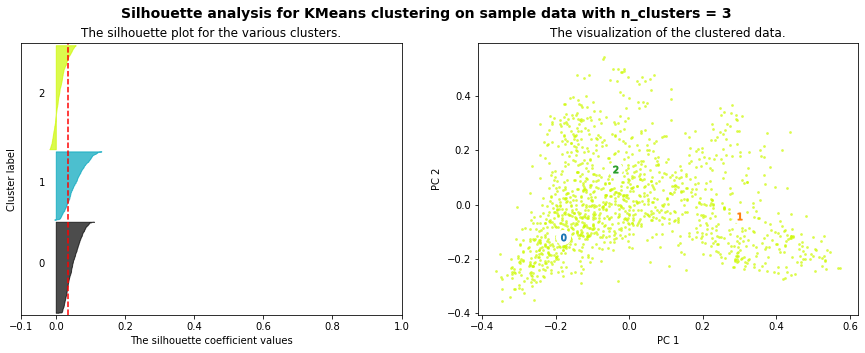

For n_clusters = 3, The average silhouette_score is : 0.036


In [86]:
X = izvestiiaTFVects.toarray()
plotSilhouette(3, X)

2020-06-17 20:47:47 WARNING: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


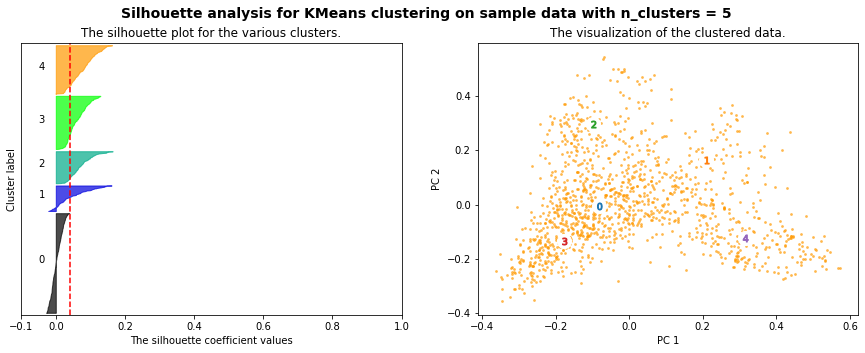

For n_clusters = 5, The average silhouette_score is : 0.041


In [87]:
X = izvestiiaTFVects.toarray()
plotSilhouette(5, X)

2020-06-17 20:47:49 WARNING: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


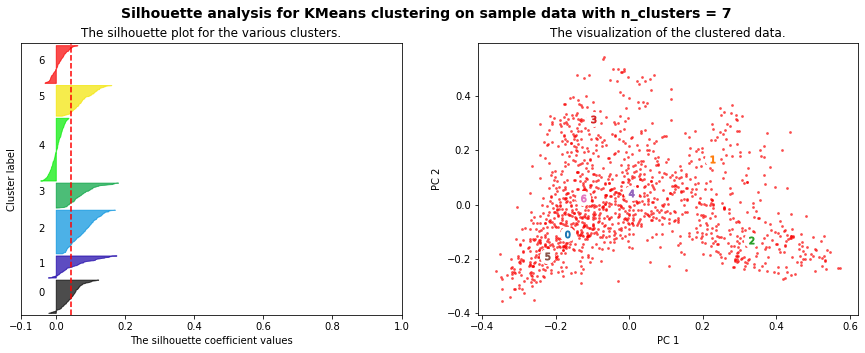

For n_clusters = 7, The average silhouette_score is : 0.043


In [88]:
X = izvestiiaTFVects.toarray()
plotSilhouette(7, X)

2020-06-17 20:47:52 WARNING: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


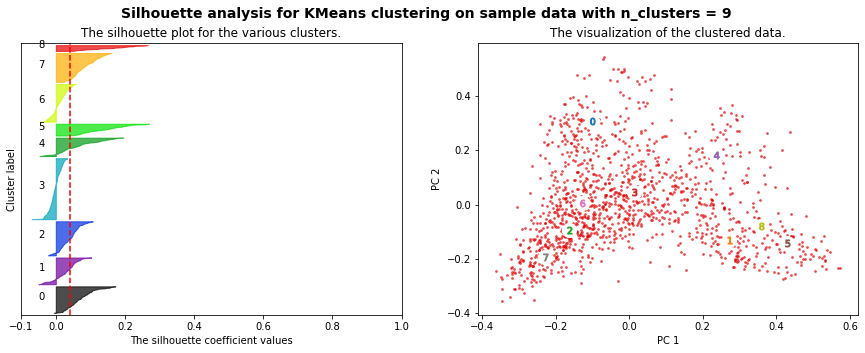

For n_clusters = 9, The average silhouette_score is : 0.041


In [89]:
X = izvestiiaTFVects.toarray()
plotSilhouette(9, X)

As is seen from the data above, once clusters go below or above seven, the silhouette score starts to drop. Examining the visualization provided alongside the plot reveals that 5 clusters seems to have the most coherent clustering. However, I will go by the silhouette score, and continue to interogate seven clisters. We will take a closer look at that plot later on.

Sometimes, even with high scores, the resulting clusters do not make sense. Therefore it is important to interrogate the clusters themselves, to make sure that they are comprehensible.

In [26]:
#7
terms = izTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km7.cluster_centers_.argsort()[:, ::-1]
for i in range(7):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 фильм
 матч
 серия
 команда
 чемпионат
 новость
 спорт
 сборная
 игра
 ночь
 концерт
 иа
 клуб
 русский
 музыка
 вечер
 играть
 минута
 ня
 язык


Cluster 1:
 деньги
 суд
 закон
 доллар
 ребенок
 театр
 русский
 выборы
 бывший
 тело
 машина
 ельцин
 военный
 писать
 война
 факс
 жить
 сообщить
 александр
 рф


Cluster 2:
 банк
 компания
 доллар
 миллиард
 финансовый
 валютный
 акция
 биржа
 бумага
 бюджет
 рост
 кредит
 объем
 инвестиция
 курс
 валюта
 триллион
 банковский
 проект
 ставка


Cluster 3:
 ядерный
 вооружение
 цк
 оружие
 иа
 военный
 сотрудничество
 американский
 делегация
 кпсс
 переговоры
 тасса
 оон
 визит
 безопасность
 секретарь
 война
 иностранный
 корр
 европа


Cluster 4:
 ул
 тело
 факс
 телефон
 компьютер
 склад
 оборудование
 банк
 товар
 ао
 выставка
 адрес
 поставка
 гарантия
 продажа
 торговый
 предлагать
 обслуживание
 компания
 автомобиль


Cluster 5:
 иа
 ие
 ти
 ми
 ив
 де
 ре
 иг
 ии
 депутат
 про
 ть
 нести
 верховный

Other than cluster 5, these seem to make sense. Lets add them to our data frame.

In [ ]:
base_df['kmeans_predictions_7'] = km7.labels_

# Interrogating the texts

Now that we have a general idea of what the topics look like, lets examine the topics within the context of the texts. The following cells take the vector representations of the texts, and convert them into arrays, which can then be plotted.

In [27]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(izvestiiaTFVects.toarray())
reduced_data = pca.transform(izvestiiaTFVects.toarray())

In [28]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [29]:
colordict = {
    0: 'red',
    1: 'orange',
    2: 'yellow',
    3: 'green',
    4: 'blue',
    5: 'purple',
    6: 'black'
            }

colors = [colordict[c] for c in base_df['kmeans_predictions_7']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([(0, 'red'), (1, 'orange'), (2, 'yellow'), (3, 'green'), (4, 'blue'), (5, 'purple'), (6, 'black')])


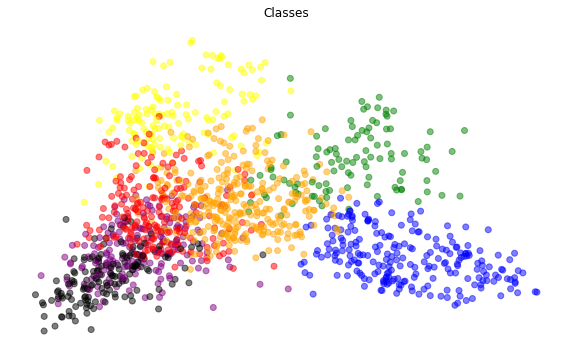

In [31]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('Classes')
plt.show()

As we can see from the above plot, the seven categories/clusters are more or less homogeneous and distinct. Lets add words to this plot, to see which extert the most pull.

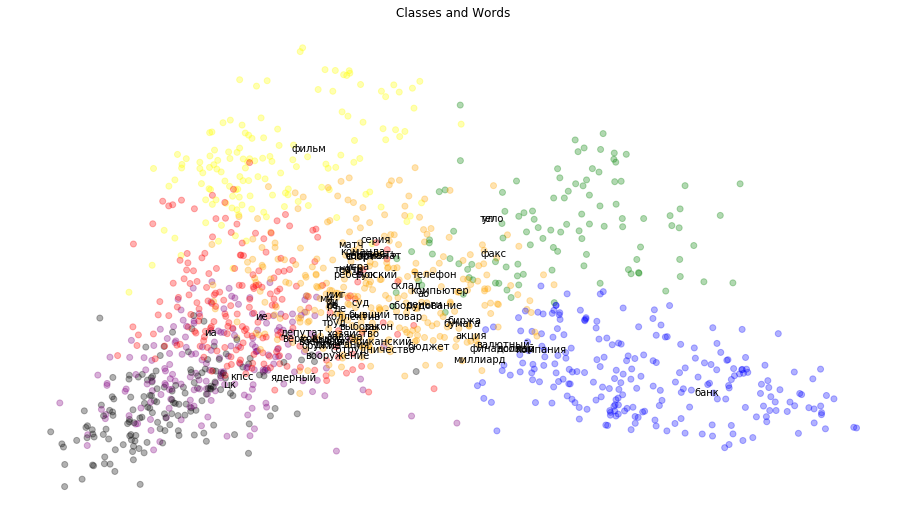

In [33]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('Classes and Words')
plt.show()

This is the same plot, but with the most distinguishable words added on top. We can see that the word "bank" exterts a strong pull on the blue category, and the word "film" exters a strong pull on the yelloe category. Most other words seem to be clustered more or less in the middle. 

# Dynamic Topic Modelling

Now that we have determined the optimal number of clusters, it is time to attempt Dynamic Topic Modelling. This takes a standard topic modelling model, and and analyzes the changes in the weights of certain words over a specified variable. Most commonly this variable is time. 

First, we need to specify the variable that will be tracked. In my case I use years. The following cell counts all of the appearances of a a year in the year column, which will then be used to specify the time slices.

In [90]:
base_df["year"].value_counts()

1995    172
1996    148
1997    115
1992    107
1991     96
1989     90
1987     78
1986     78
1985     78
1990     77
1993     72
1994     71
1984     66
1988     56
Name: year, dtype: int64

The following time slices correspond to the years 1991, 1992, ..., 1996, 1997.

In [91]:
docs_per_time_slice = [66, 78, 78, 78, 56, 90, 77, 96, 107, 72, 71, 172, 148, 115] # 14

In [92]:
izTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, norm='l2')

izvestiiaTFVects = izTFVectorizer.fit_transform(base_df['lemmas_clean_string'])

In [93]:
izvestiiaTFVects

<1304x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 376986 stored elements in Compressed Sparse Row format>

In [94]:
print(izvestiiaTFVects.shape)

(1304, 1000)


In [96]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]
base_df['reduced_lemmas'] = base_df['lemmas_clean'].apply(lambda x: dropMissing(x, izTFVectorizer.vocabulary_.keys()))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [98]:
dictionary = gensim.corpora.Dictionary(base_df['reduced_lemmas'])

In [99]:
corpus = [dictionary.doc2bow(text) for text in base_df['reduced_lemmas']]

In [100]:
gensim.corpora.MmCorpus.serialize('df.mm', corpus)
dfcorpus = gensim.corpora.MmCorpus('df.mm')

Here I load a model that has been pre-trained on my corpus. Ussually training this model can take 6-8 hours.

In [101]:
ldaseq = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")

And now the fun begins. The following plots represent each time slice, and the topics within them. Topics are presented based on their distance from each other. On the other side of the screen is found a list of the most salient/relevant words to a particualr topic.

In [102]:
# 1984
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=0, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [103]:
#1985
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=1, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [104]:
# 1986
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=2, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [105]:
# 1987
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=3, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [106]:
# 1988
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=4, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [107]:
# 1989
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=5, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [108]:
# 1990
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=6, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [109]:
# 1991
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=7, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [117]:
# 1992
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=8, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [111]:
# 1993
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=9, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [112]:
# 1994
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=10, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [113]:
# 1995
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=11, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [114]:
# 1996
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=12, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [115]:
# 1997
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=13, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [116]:
base_df.to_json('base_df.json')